# Understanding Meta Learners

In many setting, we are not just interested in understanding a causal effect, but also whether this effect is **different for different users**. We might be interested in understanding is a drug has side effects that are different for people of different age. Or we might be interested in understanding if an ad campaign is particularly effective in certain geographical areas. 

This knowledge is crucial because it allows us to **target** the treatment. If a drug has sever side-effects for kids, we might want to restrict its distribution only to adults. Or if an ad campaign is effective only in english-speaking countries it is not worth showing it elsewhere.

In this blog post we are going to explore some approaches to uncover **treatment effect heterogeneity**. In particular, we are going to explore methods that try to leverage the flexibility of **machine learning** algorithms. 

## Example

Suppose we were a company interested in understanding how much a new **premium feature** increases revenue. In particular, we know that users of different **age** have different spending attitudes and we suspect that the impact of the premium feature could also be different depending on the age of the user.

This information might be very important, for example for **advertisement targeting** or **discount design**. If we discover that the premium feature increases revenue for a particular set of users, we might want to target advertisement towards that group, or offer them personalized discounts.

To understand the effect of the premium feature on revenue, the run an [**AB test**](https://en.wikipedia.org/wiki/A/B_testing) in which we randomly give access to the premium feature to 10% of the users. The feature is **expensive** and we cannot afford to give it for free to more users. Hopefully a 10% treatment probability is enough.

We generate the simulated data using the data generating process `dgp_premium()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_premium

In [3]:
dgp = dgp_premium()
df = dgp.generate_data(seed=5)
df.head()

,revenue,premium,age
0,10.62,True,27.32
1,10.35,True,54.57
2,10.13,False,26.68
3,9.97,False,56.58
4,10.16,False,38.51


We have data on 300 users, for whom we observe the `revenue` they generate and whether they were given the `premium` feature. Moreover, we also record the `age` of the users.

To understand whether randomization worked, we use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

In [4]:
from causalml.match import create_table_one

create_table_one(df, 'premium', ['age', 'revenue'])

,Control,Treatment,SMD
Variable,,,
n,269,31,
age,39.01 (12.11),38.43 (13.26),-0.0454
revenue,10.04 (0.16),10.56 (0.23),2.5905


Most users are in the control group and only 31 users have received the premium feature. Average `age` is comparable across groups (SMD<1), while it seems that the premium feature increases `revenue` by 2.6$ per user, on average.

Does the effect of the `premium` feature differ by `age`?

One simple approach could me to regress `revenue` on a full interaction of `premium` and age.

In [5]:
linear_model = smf.ols('revenue ~ premium * age', data=df).fit()
linear_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0244,0.034,292.716,0.000,9.957,10.092
premium[T.True],0.5948,0.099,6.007,0.000,0.400,0.790
age,0.0005,0.001,0.570,0.569,-0.001,0.002
premium[T.True]:age,-0.0021,0.002,-0.863,0.389,-0.007,0.003


The interaction coefficient is close to zero and not significant. It seems that there is not a different effect of `premium` by `age`. But is it true? The interaction coefficient only captures linear relationships. What if the relationship is **non-linear**?

We can check it by directly **plotting the raw data**. We plot revenue by age, splitting the data between `premium` users and non-premium users.

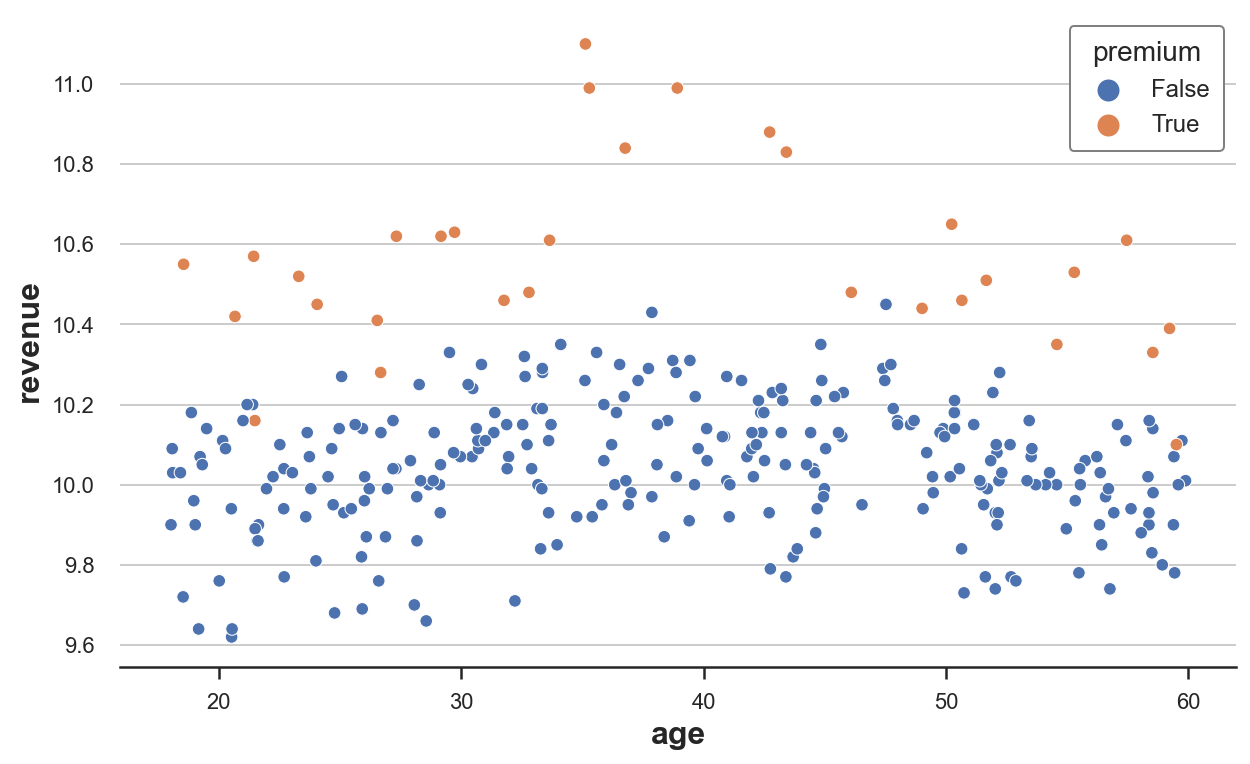

In [6]:
sns.scatterplot(data=df, x='age', y='revenue', hue='premium', s=40);

From the raw data, it looks like revenue is generally higher for people between 30 and 40 and `premium` has a particularly strong effect for people between 35 and 45/50.

We can visualize the estimated revenue by age with and without treatment.

In [7]:
def plot_TE(df, true_te=False):
    sns.scatterplot(data=df, x='age', y='revenue', hue='premium', s=40, legend=True)
    sns.lineplot(df['age'], df['mu0_hat'], label='$\mu_0$')
    sns.lineplot(df['age'], df['mu1_hat'], label='$\mu_1$')
    if true_te:
        plt.fill_between(df['age'], df['y0'], df['y0'] + df['y1'], color='grey', alpha=0.2, label="True TE")
    plt.title('Distribution of revenue by age and premium status')

We first compute the predicted revenue with ($\mu_1$) and without `premium` subscription ($\mu_0$) and we plot them together with the raw data.

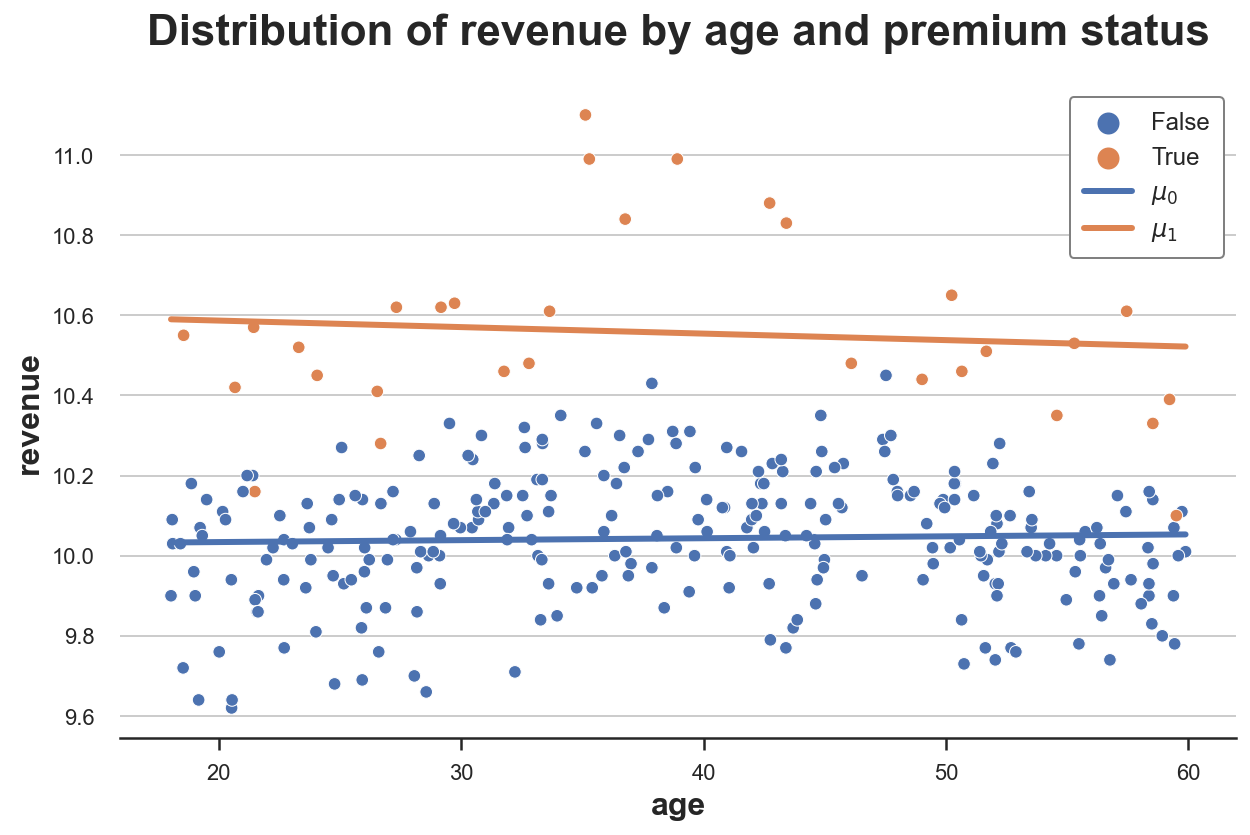

In [8]:
df['mu0_hat'] = linear_model.predict(df.assign(premium=0))
df['mu1_hat'] = linear_model.predict(df.assign(premium=1))
plot_TE(df)

As we can see, the orange line is higher than the blue line, suggesting a positive effect of `premium` on `revenue`. However, the two lines are essentially **parallel**, suggesting no heterogeneity in treatment effects.

Can we be more precise? Is there a way to estimate this treatment heterogeneity in a **flexible way**, without assuming functional forms?

The answer is **yes**! We can use machine learning methods to flexibly estimate heterogeneous treatment effects. In particular, in this blog post we are going to inspect three basic and popular methods:

- S-learner
- T-learner
- X-learner

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, D_i, Y_i)$ comprised of 

- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$ (`premium`)
- a response $Y_i \in \mathbb R$ (`revenue`)
- a feature vector $X_i \in \mathbb R^n$ (`age`)

We are interested in **estimating the average treatment effect**.

$$
\tau = \mathbb E \Big[ Y_i^{(1)} - Y_i^{(0)} \Big]
$$

Where $Y_i^{(d)}$ indicates the potential outcome of individual $i$ under treatment status $d$. We also make the following assumptions.

**Assumption 1: stable unit treatment value (SUTVA)**

$$
Y^{(d)} \perp D
$$

i.e. the potential outcome does not depend on the treatment status. In our case, we are ruling out the fact that another user selecting the `premium` feature might affect my effect of `premium` on `revenue`. The most common setting where SUTVA is violated is in presence of **network effects**: if a friend of mine uses a social network increases my utility from using it.

## S-Learner

The simplest meta-algorithm is the **single learner or S-learner**. To build the S-learner estimator, we fit a single model for all observations.

$$
\mu(z) = \mathbb E \left[ Y_i \ \big | \ (X_i, D_i) = z \right]
$$

the estimator is given by the difference between the predicted values evaluated with and without the treatment, $d=1$ and $d=0$.

$$
\hat \tau_{S} (x) = \hat \mu(x,1) - \hat \mu(x,0)
$$

In [24]:
def S_learner(dgp, model, y, D, X):
    temp = dgp.generate_data(true_te=True).sort_values(X)
    mu = model.fit(temp[X + [D]], temp[y])
    temp['mu0_hat'] = mu.predict(temp[X + [D]].assign(premium=0))
    temp['mu1_hat'] = mu.predict(temp[X + [D]].assign(premium=1))
    plot_TE(temp, true_te=True)

Let's use a [**decision tree regression**](https://en.wikipedia.org/wiki/Decision_tree_learning) model to build the the S-learner, using the `DecisionTreeRegressor` function from the [`sklearn`](https://scikit-learn.org/) package. I won't go into details about decision trees here, but I will just say that it's a non-parametric estimator that uses the training data to split the state space (`premium` and `age` in our case) into blocks and predicts the outcome (`revenue` in our case) as its average value within block. 

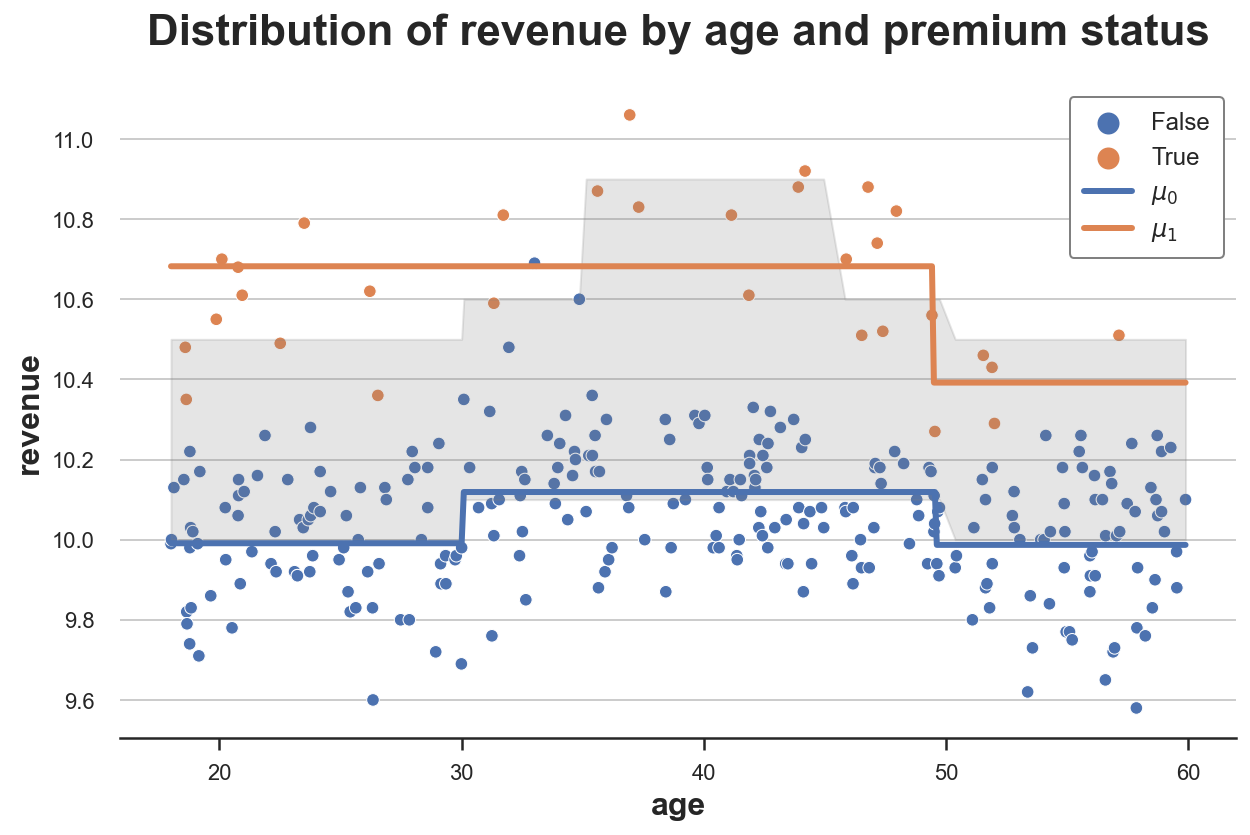

In [25]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_impurity_decrease=0.001)
S_learner(dgp, model, y="revenue", D="premium", X=["age"])

The plot depicts the data together with the response functions $\hat \mu(x,1)$ and $\hat \mu(x,0)$. I have also plotted in grey the area between the true response functions: the true treatment effects.

As we can see, the S-learner is flexible enough to understand that there is a difference in levels between treatment and control group (we have two separate lines). It also captures well the response function for the control group, $\hat \mu(x,0)$, but not so well the control function for the treatment group, $\hat \mu(x,1)$.

The **problem** with the S-learner is that it is learning a **single model** so we have to hope that the model uncovers heterogeneity in the treatment $D$, but it might not be the case. Moreover, if the model is heavily regularized because of the high dimensionality of $X$, it **might not recover any treatment effect**. For example, with decision trees, we might not split on the treatment $D$.

## T-learner

To build the **two-learner or T-learner** estimator, we fit two different models, one for treated units and one for control units.

$$
\mu^{(1)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = 1 \right] \qquad ; \qquad \mu^{(0)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = 0 \right]
$$

the estimator is given by the difference between the predicted values of the two algorithms.

$$
\hat \tau_{T} (x) = \hat \mu^{(1)}(x) - \hat \mu^{(0)}(x)
$$

In [31]:
def T_learner(df, model, y, D, X):
    temp = dgp.generate_data(true_te=True).sort_values(X)
    mu0 = model.fit(temp.loc[temp[D]==0, X], temp.loc[temp[D]==0, y])
    temp['mu0_hat'] = mu0.predict(temp[X])
    mu1 = model.fit(temp.loc[temp[D]==1, X], temp.loc[temp[D]==1, y])
    temp['mu1_hat'] = mu1.predict(temp[X])
    plot_TE(temp, true_te=True)

We use a decision tree regression model as before but, this time, we fit two separate decision trees for the treatment and control group.

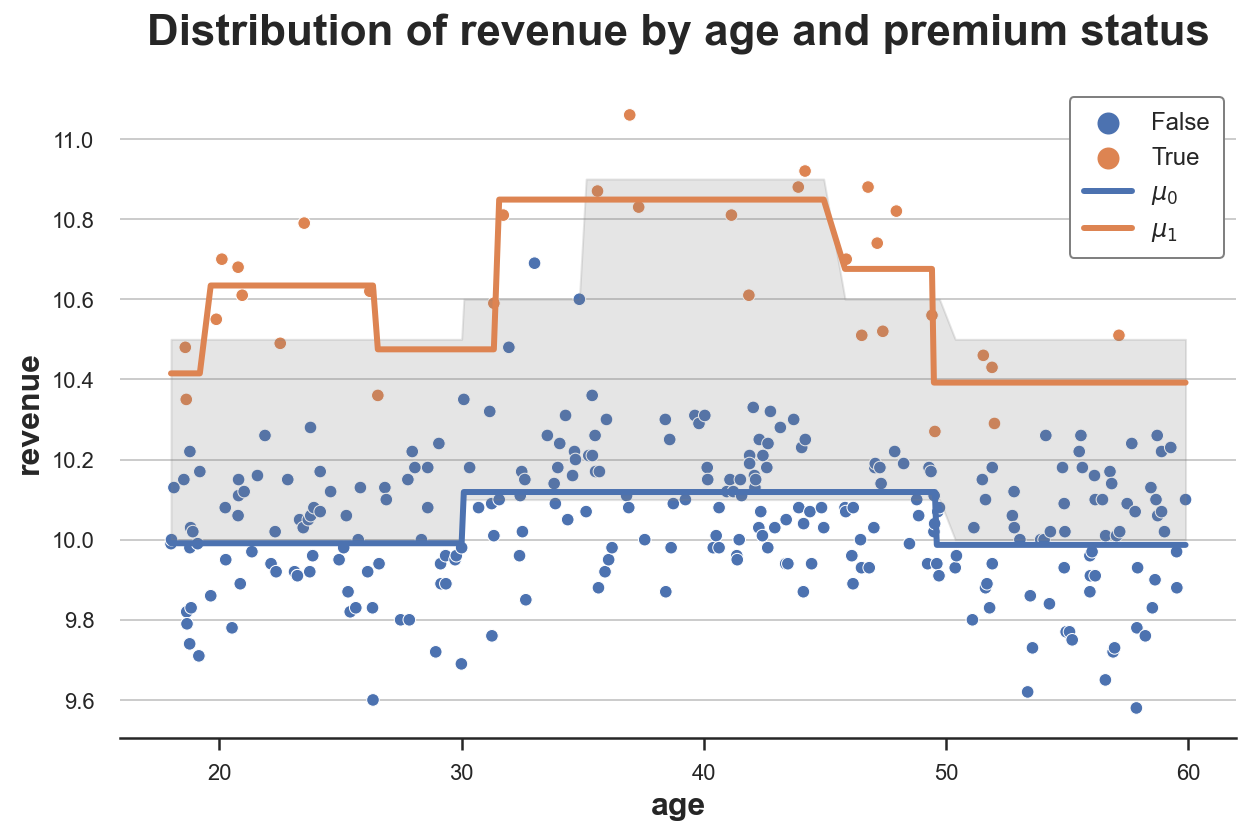

In [32]:
T_learner(dgp, model, y="revenue", D="premium", X=["age"])

As we can see, the T-learner is much **more flexible** than the S-learner because it fits two separate models. The response function for the control group, $\hat \mu(x,0)$, is still very accurate and the response function for the treatment group, $\hat \mu(x,1)$, is more flexible than before.

The **problem** now is that we are **using just a fraction of the data** for each prediction problem, while the S-learner was using all the data. By fitting two separate models we are losing some information. Moreover, by using two different models we might get **heterogeneity where there is none**. For example, with decision trees, we will probably get different splits with different samples even if the data generating process is the same.

### X-learner

The **cross-learner or X-learner** estimator is an extension of the T-learner estimator. It is built in the following way:

1. As for the T-learner, compute separate models for $\mu^{(1)}(x)$ and $\mu^{(0)}(x)$ using the treated and control units, respectively

2. Compute the estimated treatment effects as

$$
\Delta_i (x) = 
\begin{cases}
Y_i - \hat \mu^{(0)}(x) &\quad \text{ if } T_i = 1
\newline
\hat \mu^{(1)}(x) - Y_i &\quad \text{ if } T_i = 0
\end{cases}
$$

3. Predicting $\Delta$ from $X$, compute $\hat \tau^{(0)}(x)$ from treated units and  $\hat \tau^{(1)}(x)$ from control units

4. Estimate the [**propensity score**](https://en.wikipedia.org/wiki/Propensity_score_matching) $e(x) = \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right]$

5. Compute the treatment effects

$$
\hat \tau_X(x) = \hat \tau^{(0)}(x) \hat e(x) + \hat \tau^{(1)}(x) (1 - \hat e(x))
$$

Can we still recover **pseudo response functions**? Yes!

Which we can rewrite the treatment effects as

$$
\begin{align}
\hat \tau_X(x) & = \hat \tau^{(0)}(x) \hat e(x) + \hat \tau^{(1)}(x) (1 - \hat e(x)) = \newline
&= \hat e(x) \left[ \hat \mu^{(1)}(x) - Y_i^{(0)} \right] + (1 - \hat e(x)) \left[ Y_i^{(1)} - \hat \mu^{(0)}(x) \right] = \newline
&= \left[ \hat e(x) \hat \mu^{(1)}(x) + (1 - \hat e(x)) Y_i^{(1)} \right] - \left[ \hat e(x) Y_i^{(0)} + (1 - \hat e(x))  \hat \mu^{(0)}(x) \right]
\end{align}
$$

So that the pseudo response functions estimated by the X-learner are

$$
\begin{align}
\tilde \mu_i^{(1)} (x) &= \hat e(x) \hat \mu^{(1)}(x) + (1 - \hat e(x)) Y_i^{(1)} \newline
\tilde \mu_i^{(0)} (x) &=  \hat e(x) Y_i^{(0)} + (1 - \hat e(x)) \hat \mu^{(0)}(x) 
\end{align}
$$

As we can see, the X-learner combines the true values $Y_i^{(d)}$ with the estimated ones $\mu_i^{(d)} (x)$ weighting by the [**propensity scores**](https://en.wikipedia.org/wiki/Propensity_score_matching) $e_i(x)$, i.e. the estimated treatment probabilities.

**What does it mean?** It means that if we have many more observations for one group (in our case the control group), the control response function $\hat \mu^{(0)}(x) $ will get most of the weight. Instead, for the other group (the treatment group in our case), the actual observations $Y_i^{(1)}$ will get most of the weight.

To illustrate the method, I am going to build pseudo response functions by approximating $Y_i^{(d)}$ using the nearest observation, using the `KNeighborsRegressor` function. I estimate the propensity scores via [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) using the `LogisticRegressionCV` function.

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegressionCV

def X_learner(df, model, y, D, X):
    temp = dgp.generate_data(true_te=True).sort_values(X)
    
    # Mu
    mu0 = model.fit(temp.loc[temp[D]==0, X], temp.loc[temp[D]==0, y])
    temp['mu0_hat_'] = mu0.predict(temp[X])
    mu1 = model.fit(temp.loc[temp[D]==1, X], temp.loc[temp[D]==1, y])
    temp['mu1_hat_'] = mu1.predict(temp[X])
    
    # Y
    y0 = KNeighborsRegressor(n_neighbors=1).fit(temp.loc[temp[D]==0, X], temp.loc[temp[D]==0, y])
    temp['y0_hat'] = y0.predict(temp[X])
    y1 = KNeighborsRegressor(n_neighbors=1).fit(temp.loc[temp[D]==1, X], temp.loc[temp[D]==1, y])
    temp['y1_hat'] = y1.predict(temp[X])
    
    # Weight
    e = LogisticRegressionCV().fit(y=temp[D], X=temp[X]).predict_proba(temp[X])[:,1]
    temp['mu0_hat'] = e * temp['y0_hat'] + (1-e) * temp['mu0_hat_']
    temp['mu1_hat'] = (1-e) * temp['y1_hat'] + e * temp['mu1_hat_']
    
    # Plot
    plot_TE(temp, true_te=True)

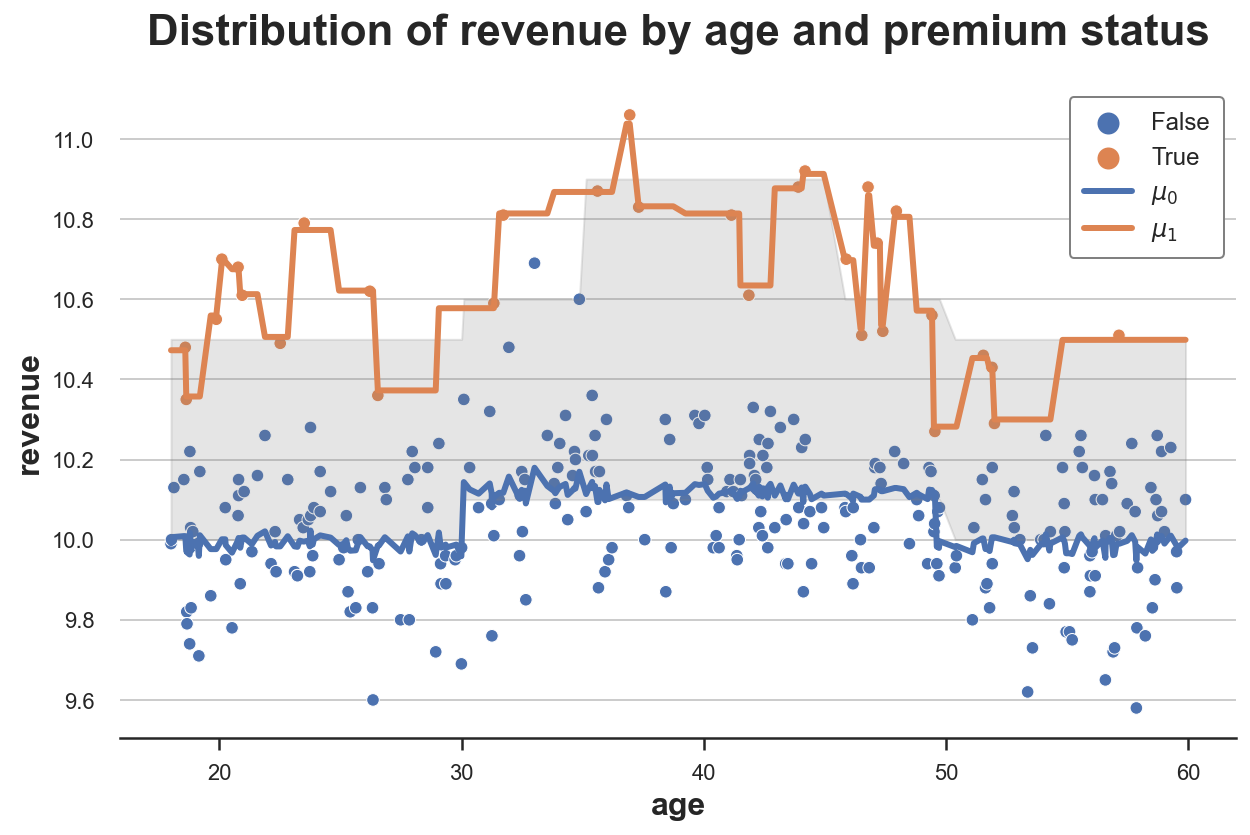

In [36]:
X_learner(df, model, y="revenue", D="premium", X=["age"])

As we can clearly see from this graph, the main advantage of **X-learners** is that it adapts the **flexibility** of the response functions to the context. In areas of the state space where we have a lot of data, it mostly uses the estimated response function, in areas of the state space with few data, it uses the observation themselves.

## Conclusion

In this post we have seen different estimators that leverage flexible **machine learning** algorithms to estimate **heterogeneous treatment effects**. The estimators differ for their degree of sophistication: the S-learner fits a single estimator including the treatment indicator as a covariate. The T-learner fits two separate estimators for the treatment and control group. Lastly, the X-learner is an extension of the T-learner that allows for different degrees of flexibility depending on the amount of data available across treatment and control group.

### References

[1] S. Künzel, J. Sekhon, P. Bickel, B. Yu, [Metalearners for estimating heterogeneous treatment effects using machine learning](https://www.pnas.org/doi/abs/10.1073/pnas.1804597116) (2019), *PNAS*.

### Related Articles

- [Matching, Weighting, or Regression?](https://towardsdatascience.com/99bf5cffa0d9)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/meta.ipynb